In [1]:
import requests 
import nltk
from selenium import webdriver
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import math
from IPython.display import Markdown, display
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt    
from dataHack import removeColl 
%matplotlib inline
import warnings
import scipy
warnings.filterwarnings('ignore')
import networkx as nx
%load_ext autotime
def printmd(string):
    display(Markdown(string))
from selenium.webdriver.common.keys import Keys

In [2]:
sentiment_dict={0 : 'negative',
                1 : 'somewhat negative',
                2 : 'neutral',
                3 : 'somewhat positive',
                4 : 'positive'}

time: 2 ms


In [194]:
from nltk.corpus import stopwords
import re
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words1 = [w for w in words if not w in stops]   
    from nltk.stem.porter import PorterStemmer
    stem=PorterStemmer().stem
    meaningful_words=[stem(w) for w in meaningful_words1] 
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

time: 15 ms


In [4]:
data= pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)

time: 1.69 s


In [5]:
pick_index=data[data['sentiment']==1].tail(3).index.tolist()+data[data['sentiment']==0].tail(3).index.tolist()

time: 9 ms


In [6]:
data= data.iloc[pick_index].reset_index(drop=True)
data

,id,sentiment,review
0,"""5974_7""",1,"""I heard about this movie when watching VH1's ..."
1,"""2034_9""",1,"""I've never been huge on IMAX films. They're c..."
2,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."
3,"""5064_1""",0,"""I don't believe they made this film. Complete..."
4,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
5,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


time: 125 ms


In [7]:
data['rating']=data['id'].apply(lambda l:l.replace('"','').split('_')[1]).astype(int)
data['id']=data['id'].apply(lambda l:l.replace('"','').split('_')[0]).astype(int)

time: 35 ms


In [8]:
data

,id,sentiment,review,rating
0,5974,1,"""I heard about this movie when watching VH1's ...",7
1,2034,1,"""I've never been huge on IMAX films. They're c...",9
2,8478,1,"""I saw this movie as a child and it broke my h...",8
3,5064,0,"""I don't believe they made this film. Complete...",1
4,10905,0,"""Guy is a loser. Can't get girls, needs to bui...",3
5,10194,0,"""This 30 minute documentary Buñuel made in the...",3


time: 14 ms


In [9]:
corpus=''.join(data['review'].tolist())
corpus

'"I heard about this movie when watching VH1\'s \\"100 Most Metal Moments.\\" On the segment, Gene Simmons (who played a cameo) and several other interviewees discussed how utterly awful this movie is. Unlike most people, I\'m often more curious about checking out movies that have reputations for being ridiculously bad than, say, a masterpiece of cinema. The advantage of having that sort of attitude is half the time I find out that the movies are nowhere near as bad as people said, and I end up enjoying them a lot more than I initially expected. That was my experience with \\"Trick or Treat.\\" Now, it\'s hard to make a movie about a teenage boy who receives messages from a dead heavy metal star by playing one of his vintage records backwards without people scoffing at the premise. Sure, it\'s certainly a strange premise, but one that\'s never been done before! Give the filmmakers points for originality for Pete\'s sake! If you\'re looking to buy the DVD, having no prior knowledge of t

time: 4 ms


In [10]:
data['clean_review']=data['review'].apply(lambda l:re.sub(r'\W+', " ", BeautifulSoup(l).get_text()))
#re.sub("[^a-zA-Z]", " ", review_text)

time: 103 ms


In [11]:
data

,id,sentiment,review,rating,clean_review
0,5974,1,"""I heard about this movie when watching VH1's ...",7,I heard about this movie when watching VH1 s ...
1,2034,1,"""I've never been huge on IMAX films. They're c...",9,I ve never been huge on IMAX films They re co...
2,8478,1,"""I saw this movie as a child and it broke my h...",8,I saw this movie as a child and it broke my h...
3,5064,0,"""I don't believe they made this film. Complete...",1,I don t believe they made this film Completel...
4,10905,0,"""Guy is a loser. Can't get girls, needs to bui...",3,Guy is a loser Can t get girls needs to build...
5,10194,0,"""This 30 minute documentary Buñuel made in the...",3,This 30 minute documentary Bu uel made in the...


time: 70 ms


In [12]:
x=data[['id','clean_review']]#.to_dict().items()

time: 251 ms


In [13]:
x['clean_review']=x['clean_review'].apply(lambda l: re.sub("[^a-zA-Z]", " ", l))

time: 63 ms


In [14]:
x['split']=x['clean_review'].apply(lambda l: l.split())

time: 70 ms


In [15]:
x[['id','split']]#.to_dict()

,id,split
0,5974,"[I, heard, about, this, movie, when, watching,..."
1,2034,"[I, ve, never, been, huge, on, IMAX, films, Th..."
2,8478,"[I, saw, this, movie, as, a, child, and, it, b..."
3,5064,"[I, don, t, believe, they, made, this, film, C..."
4,10905,"[Guy, is, a, loser, Can, t, get, girls, needs,..."
5,10194,"[This, minute, documentary, Bu, uel, made, in,..."


time: 21 ms


In [16]:
word_dict=pd.DataFrame()
for i in x.id.tolist():
    word_dict1=pd.DataFrame()
    word_dict1['word']=x[x['id']==i]['split'].tolist()[0]
    #print type(i) ,i  ,word_dict1.head() 
    word_dict1['id']=i
    word_dict=word_dict.append(word_dict1)
    

time: 82 ms


In [17]:
word_dict=word_dict#.reset_index(drop=True)

time: 2 ms


In [18]:
word_dict

,word,id
0,I,5974
1,heard,5974
2,about,5974
3,this,5974
4,movie,5974
5,when,5974
6,watching,5974
7,VH,5974
8,s,5974
9,Most,5974


time: 33 ms


In [261]:
stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
meaningful_words = [w for w in word_dict['word'].tolist() if not w in stops] 

meaningful_words

[u'I',
 u'heard',
 u'movie',
 u'watching',
 u'VH',
 u'Most',
 u'Metal',
 u'Moments',
 u'On',
 u'segment',
 u'Gene',
 u'Simmons',
 u'played',
 u'cameo',
 u'several',
 u'interviewees',
 u'discussed',
 u'utterly',
 u'awful',
 u'movie',
 u'Unlike',
 u'people',
 u'I',
 u'often',
 u'curious',
 u'checking',
 u'movies',
 u'reputations',
 u'ridiculously',
 u'bad',
 u'say',
 u'masterpiece',
 u'cinema',
 u'The',
 u'advantage',
 u'sort',
 u'attitude',
 u'half',
 u'time',
 u'I',
 u'find',
 u'movies',
 u'nowhere',
 u'near',
 u'bad',
 u'people',
 u'said',
 u'I',
 u'end',
 u'enjoying',
 u'lot',
 u'I',
 u'initially',
 u'expected',
 u'That',
 u'experience',
 u'Trick',
 u'Treat',
 u'Now',
 u'hard',
 u'make',
 u'movie',
 u'teenage',
 u'boy',
 u'receives',
 u'messages',
 u'dead',
 u'heavy',
 u'metal',
 u'star',
 u'playing',
 u'one',
 u'vintage',
 u'records',
 u'backwards',
 u'without',
 u'people',
 u'scoffing',
 u'premise',
 u'Sure',
 u'certainly',
 u'strange',
 u'premise',
 u'one',
 u'never',
 u'done',
 u

time: 48 ms


In [264]:
set(meaningful_words)-set(meaningful_words1)

{u'Adam',
 u'And',
 u'Animal',
 u'Axel',
 u'BBC',
 u'Because',
 u'Body',
 u'Brazilian',
 u'Bu',
 u'But',
 u'California',
 u'Can',
 u'Chirin',
 u'Completely',
 u'DVD',
 u'Daeseleire',
 u'Doesn',
 u'European',
 u'Everest',
 u'Every',
 u'First',
 u'For',
 u'Gaye',
 u'Gene',
 u'Get',
 u'Give',
 u'God',
 u'Guy',
 u'Here',
 u'However',
 u'Human',
 u'I',
 u'IMAX',
 u'If',
 u'It',
 u'Let',
 u'Marvin',
 u'Metal',
 u'Moments',
 u'Most',
 u'No',
 u'Now',
 u'On',
 u'One',
 u'Osbourne',
 u'Our',
 u'Ozzy',
 u'Pete',
 u'Pi',
 u'Reverend',
 u'Rob',
 u'Sandler',
 u'Seen',
 u'Simmons',
 u'So',
 u'Spain',
 u'Spirit',
 u'Stories',
 u'Sure',
 u'Teaching',
 u'Team',
 u'That',
 u'The',
 u'There',
 u'They',
 u'This',
 u'Treat',
 u'Trick',
 u'Unlike',
 u'VH',
 u'Western',
 u'What',
 u'Whoa',
 u'Why',
 u'Wild',
 u'Wolf',
 u'acids',
 u'acting',
 u'advantage',
 u'alienated',
 u'alone',
 u'already',
 u'altogether',
 u'anime',
 u'another',
 u'attitude',
 u'attractive',
 u'awful',
 u'baby',
 u'backwards',
 u'beautif

time: 21 ms


In [265]:
meaningful_words1=levenshtein_dist.word_i.drop_duplicates().tolist()

time: 7 ms


In [266]:
word_dict['Meaningful']=[word_dict['word'].isin(meaningful_words)][0]

time: 27 ms


In [267]:
word_dict[word_dict['Meaningful']]

,word,id,Meaningful
0,I,5974,True
1,heard,5974,True
4,movie,5974,True
6,watching,5974,True
7,VH,5974,True
9,Most,5974,True
10,Metal,5974,True
11,Moments,5974,True
12,On,5974,True
14,segment,5974,True


time: 159 ms


In [268]:
----------------------------

SyntaxError: invalid syntax (<ipython-input-268-8a7a5d89be62>, line 1)

In [269]:
word_dict.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\WordList.csv',index=False)

time: 71 ms


In [20]:
data.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\Data.csv',index=False)

time: 4 ms


In [21]:
def levenshtein(s1,s2): 
    if len(s1) > len(s2):
        s1,s2 = s2,s1 
    distances = range(len(s1) + 1) 
    for index2,char2 in enumerate(s2):
        newDistances = [index2+1]
        for index1,char1 in enumerate(s1):
            if char1 == char2:
                newDistances.append(distances[index1]) 
            else:
                 newDistances.append(1 + min((distances[index1], distances[index1+1], newDistances[-1]))) 
        distances = newDistances 
    return distances[-1]


time: 9 ms


In [22]:
uni_word=word_dict['word'].unique().tolist()


time: 13 ms


In [23]:
print len(uni_word)
uni_word=[l.lower() for l in uni_word]
uni_word=list(set(uni_word))
print len(uni_word)

597
568
time: 3 ms


In [24]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))                  
   
meaningful_words = [w for w in uni_word if not w in stops]   
  

time: 295 ms


In [25]:
from nltk.stem.wordnet import WordNetLemmatizer 
lem = WordNetLemmatizer()

time: 2 ms


In [36]:
from nltk.stem.porter import PorterStemmer
stem=PorterStemmer().stem

time: 3 ms


In [37]:
meaningful_tup =[(stem(w),w) for w in meaningful_words ]  

time: 11 ms


In [92]:
pd.DataFrame(meaningful_tup).rename(columns={0:'Stem',1:'org_word'}).to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\stem_map.csv',index=False)

time: 6 ms


In [38]:
meaningful_words =[stem(w) for w in meaningful_words ]  

time: 12 ms


In [39]:
meaningful_words=list(set(meaningful_words))

time: 2 ms


In [40]:
printmd('### '+str(len(meaningful_words)))

### 418

time: 7 ms


In [41]:
meaningful_words

[u'rob',
 u'lack',
 u'alien',
 u'go',
 u'follow',
 u'children',
 u'inconceiv',
 u'poorest',
 u'spirit',
 u'ozzi',
 u'certainli',
 u'worth',
 u'everi',
 u'jerk',
 u'far',
 u'horror',
 u'simmon',
 u'catharsi',
 u'strang',
 u'cool',
 u'tri',
 u'school',
 u'shock',
 u'team',
 u'guy',
 u'enjoy',
 u'someday',
 u'direct',
 u'past',
 u'second',
 u'acid',
 u'clich',
 u'even',
 u'access',
 u'axel',
 u'ever',
 u'womb',
 u'poverti',
 u'never',
 u'bodi',
 u'fun',
 u'let',
 u'excess',
 u'pleasur',
 u'sinc',
 u'valu',
 u'boy',
 u'great',
 u'broken',
 u'technolog',
 u'prior',
 u'social',
 u'opinion',
 u'gene',
 u'guilti',
 u'emot',
 u'attitud',
 u'instal',
 u'plot',
 u'use',
 u'eye',
 u'wealth',
 u'would',
 u'sake',
 u'two',
 u'process',
 u'type',
 u'reced',
 u'flat',
 u'capit',
 u'babi',
 u'peopl',
 u'impress',
 u'tandem',
 u'broke',
 u'glad',
 u'hour',
 u'work',
 u'fli',
 u'heart',
 u'favourit',
 u'give',
 u'predict',
 u'high',
 u'heard',
 u'attract',
 u'lamb',
 u'huge',
 u'end',
 u'rather',
 u'anot

time: 16 ms


In [42]:
levenshtein_dist=pd.DataFrame()
from tqdm import tqdm
for i in tqdm(meaningful_words):
    for j in meaningful_words:
        temp=pd.DataFrame([i],columns={'word_i'})
        #temp['word_i']=i
        temp['word_j']=j
        temp['levenshtein']=levenshtein(i,j)
        #print temp
        levenshtein_dist=levenshtein_dist.append(temp)

100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [18:28<00:00,  4.09s/it]


time: 18min 29s


In [43]:
levenshtein_dist.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\levenshtein_dist.csv',index=False)

time: 253 ms


In [44]:
levenshtein_dist=levenshtein_dist.sort_values(['word_i','word_j']).reset_index(drop=True)

time: 421 ms


In [45]:
lev= levenshtein_dist.copy()

time: 9 ms


In [46]:
#lev=lev.rename(columns={'word_i':'word1','word_j':'word2'})
feat=lev.word_j.drop_duplicates().tolist()
lev

,word_i,word_j,levenshtein
0,access,access,0
1,access,acid,4
2,access,across,2
3,access,act,4
4,access,adam,5
5,access,admit,5
6,access,advantag,7
7,access,age,4
8,access,alien,4
9,access,alon,5


time: 332 ms


In [47]:
lev=lev.groupby(['word_i','word_j'])['levenshtein'].mean().unstack()

time: 271 ms


In [48]:
lev['array']['thing']

5

time: 6 ms


AxesImage(43.2,25.92;223.2x223.2)


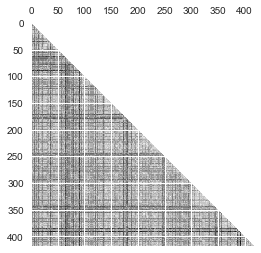

time: 769 ms


In [49]:
feat=levenshtein_dist.word_i.drop_duplicates().tolist()
corrmat=lev.as_matrix()
for i in range(len(corrmat)):
    for j in range(len(corrmat)):
        if j>i :
            corrmat[i][j]=0
corrFrame= pd.DataFrame(pd.DataFrame(corrmat,columns=feat,index=feat).unstack()).reset_index()
print plt.matshow(corrmat)
del corrmat
corrFrame=corrFrame[corrFrame[0]>0].rename(columns={0:'levenshtein'})

In [50]:
corrFrame=corrFrame.rename(columns={'level_0':'word_i','level_1':'word_j'})

time: 7 ms


In [51]:
corrFrame[(corrFrame['word_j']=='thing')&(corrFrame['word_i']=='array')]

,word_i,word_j,levenshtein
8310,array,thing,5


time: 69 ms


In [52]:
corrFrame.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\levenshtein_dist.csv',index=False)

time: 115 ms


In [53]:
corrFrame

,word_i,word_j,levenshtein
1,access,acid,4
2,access,across,2
3,access,act,4
4,access,adam,5
5,access,admit,5
6,access,advantag,7
7,access,age,4
8,access,alien,4
9,access,alon,5
10,access,alreadi,5


time: 37 ms


In [54]:
import fuzzy 
from jellyfish import soundex
#soundex = fuzzy.Soundex(4) 

time: 241 ms


In [55]:
#soundex('depth'),soundex('depg'),
soundex(u'write'),soundex(u'right')

('W630', 'R230')

time: 25 ms


In [56]:
phoenatic=corrFrame.copy()

time: 3 ms


In [57]:
del corrFrame

time: 1e+03 µs


In [58]:
phoenatic=phoenatic.drop('levenshtein',1)

time: 6 ms


In [59]:
phoenatic['sound_i']=phoenatic['word_i'].apply(lambda l: soundex(l))
phoenatic['sound_j']=phoenatic['word_j'].apply(lambda l: soundex(l))

time: 182 ms


In [60]:
phoenatic['sound_i_pre']=phoenatic['word_i'].apply(lambda l: soundex(l)[0])
phoenatic['sound_j_pre']=phoenatic['word_j'].apply(lambda l: soundex(l)[0])
phoenatic['sound_i_post']=phoenatic['word_i'].apply(lambda l: soundex(l)[1:]).astype(int)
phoenatic['sound_j_post']=phoenatic['word_j'].apply(lambda l: soundex(l)[1:]).astype(int)

time: 393 ms


In [61]:
phoenatic['Flag']=[phoenatic['sound_i_pre'] ==phoenatic['sound_j_pre']][0]

time: 24 ms


In [62]:
phoenatic['sound_diff']=np.abs(phoenatic['sound_i_post']-phoenatic['sound_j_post'])

time: 27 ms


In [63]:
phoenatic[(phoenatic['sound_diff']==0)&(phoenatic['Flag'])]

,word_i,word_j,sound_i,sound_j,sound_i_pre,sound_j_pre,sound_i_post,sound_j_post,Flag,sound_diff
421,acid,act,A230,A230,A,A,230,230,True,0
3353,alien,alon,A450,A450,A,A,450,450,True,0
9219,aw,away,A000,A000,A,A,0,0,True,0
11315,bad,beauti,B300,B300,B,B,300,300,True,0
11319,bad,bodi,B300,B300,B,B,300,300,True,0
12155,beauti,bodi,B300,B300,B,B,300,300,True,0
14671,boy,bu,B000,B000,B,B,0,0,True,0
14673,boy,buy,B000,B000,B,B,0,0,True,0
17181,bu,buy,B000,B000,B,B,0,0,True,0
18873,cameo,come,C500,C500,C,C,500,500,True,0


time: 228 ms


In [64]:
phoenatic.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\phonetic.csv',index=False)

time: 276 ms


## Jaro-winker distance

In [65]:
from jellyfish import jaro_winkler
round(jaro_winkler(u'time', u'tune'),2)

0.67

time: 5 ms


In [66]:
jaro=phoenatic[['word_i','word_j']].copy()

time: 6 ms


In [67]:
jaro['jaro_distance']=jaro.apply(lambda l :round(jaro_winkler(l[0],l[1]),2),axis=1 )

time: 3.66 s


In [68]:
jaro[jaro['jaro_distance']>0.9].sort_values('jaro_distance',ascending=False)

,word_i,word_j,jaro_distance
155450,though,thought,0.97
136176,simpl,simpli,0.97
16342,broke,broken,0.97
44416,ever,everi,0.96
66203,hear,heard,0.96
46512,except,expect,0.96
66204,hear,heart,0.96
134501,short,shot,0.95
27236,complet,complex,0.94
110198,pleas,pleasur,0.94


time: 29 ms


In [69]:
jaro.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\jaro.csv',index=False)

time: 143 ms


## Cosine Similarity

In [209]:
import math
from collections import Counter
def get_cosine(vec1, vec2):
    common = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in common])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()]) 
    sum2 = sum([vec2[x]**2 for x in vec2.keys()]) 
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
   
    if not denominator:
        return 0.0 
    else:
        return float(numerator) / denominator

def text_to_vector(text): 
    words = text.split() 
    return Counter(words)


time: 13 ms


In [210]:
cosineFrame=jaro.drop('jaro_distance',1)

time: 94 ms


In [211]:
cosineFrame.head()

,word_i,word_j
1,access,acid
2,access,across
3,access,act
4,access,adam
5,access,admit


time: 163 ms


In [212]:
#text_to_vector(text1)
get_cosine(text_to_vector('access'), text_to_vector('access this'))

0.7071067811865475

time: 100 ms


In [213]:
data[['review','review']].apply(lambda l:get_cosine(text_to_vector(l[0]),text_to_vector(l[1])),axis=1).astype(float).value_counts()

1.0    2
1.0    2
1.0    1
1.0    1
dtype: int64

time: 76 ms


In [214]:
data[['review','review']]

,review,review
0,"""I heard about this movie when watching VH1's ...","""I heard about this movie when watching VH1's ..."
1,"""I've never been huge on IMAX films. They're c...","""I've never been huge on IMAX films. They're c..."
2,"""I saw this movie as a child and it broke my h...","""I saw this movie as a child and it broke my h..."
3,"""I don't believe they made this film. Complete...","""I don't believe they made this film. Complete..."
4,"""Guy is a loser. Can't get girls, needs to bui...","""Guy is a loser. Can't get girls, needs to bui..."
5,"""This 30 minute documentary Buñuel made in the...","""This 30 minute documentary Buñuel made in the..."


time: 59 ms


In [215]:
sim =pd.DataFrame()
for i,k in enumerate(data['clean_review']):
    for j in data['clean_review'][i+1:]:
        cs=get_cosine(text_to_vector(j),text_to_vector(k))
        print cs
        temp=pd.DataFrame([j],columns={'j'})
        temp['k']=k
        temp['cs']=cs
        sim=sim.append(temp)
        print temp
        
        

0.697562060511
                                                   j  \
0   I ve never been huge on IMAX films They re co...   

                                                   k        cs  
0   I heard about this movie when watching VH1 s ...  0.697562  
0.566394882222
                                                   j  \
0   I saw this movie as a child and it broke my h...   

                                                   k        cs  
0   I heard about this movie when watching VH1 s ...  0.566395  
0.56816274279
                                                   j  \
0   I don t believe they made this film Completel...   

                                                   k        cs  
0   I heard about this movie when watching VH1 s ...  0.568163  
0.537551139744
                                                   j  \
0   Guy is a loser Can t get girls needs to build...   

                                                   k        cs  
0   I heard about this movie when 

In [216]:
sim

,j,k,cs
0,I ve never been huge on IMAX films They re co...,I heard about this movie when watching VH1 s ...,0.697562
0,I saw this movie as a child and it broke my h...,I heard about this movie when watching VH1 s ...,0.566395
0,I don t believe they made this film Completel...,I heard about this movie when watching VH1 s ...,0.568163
0,Guy is a loser Can t get girls needs to build...,I heard about this movie when watching VH1 s ...,0.537551
0,This 30 minute documentary Bu uel made in the...,I heard about this movie when watching VH1 s ...,0.622274
0,I saw this movie as a child and it broke my h...,I ve never been huge on IMAX films They re co...,0.519185
0,I don t believe they made this film Completel...,I ve never been huge on IMAX films They re co...,0.504785
0,Guy is a loser Can t get girls needs to build...,I ve never been huge on IMAX films They re co...,0.496094
0,This 30 minute documentary Bu uel made in the...,I ve never been huge on IMAX films They re co...,0.608106
0,I don t believe they made this film Completel...,I saw this movie as a child and it broke my h...,0.467164


time: 20 ms


In [217]:
sim.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\CosineSim.csv',index=False)

time: 81 ms


## Topic Modelling

In [218]:
texts=data['clean_review'].apply(lambda l:review_to_words(l).split()).tolist()

time: 89 ms


In [219]:
from gensim import corpora, models
import gensim
dictionary = corpora.Dictionary(texts)

time: 81 ms


In [220]:
corpus = [dictionary.doc2bow(text) for text in texts]

time: 99 ms


In [221]:
print corpus[0]

[(0, 2), (1, 1), (2, 9), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 7), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 3), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1),

In [222]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

time: 1.12 s


In [223]:
print(ldamodel.print_topics())

[(0, u'0.020*"one" + 0.020*"movi" + 0.010*"peopl" + 0.010*"like" + 0.009*"film" + 0.008*"insid" + 0.008*"bodi" + 0.008*"uel" + 0.008*"bu" + 0.006*"bad"'), (1, u'0.031*"film" + 0.014*"first" + 0.014*"sequel" + 0.010*"like" + 0.010*"one" + 0.010*"shot" + 0.010*"charact" + 0.010*"good" + 0.010*"seri" + 0.010*"simpl"'), (2, u'0.019*"movi" + 0.016*"get" + 0.016*"stori" + 0.012*"need" + 0.012*"sandler" + 0.012*"adam" + 0.012*"child" + 0.012*"saw" + 0.012*"wolf" + 0.012*"film"')]
time: 5 ms


In [224]:
ldamodel.print_topics()[0][1].split('+')

[u'0.020*"one" ',
 u' 0.020*"movi" ',
 u' 0.010*"peopl" ',
 u' 0.010*"like" ',
 u' 0.009*"film" ',
 u' 0.008*"insid" ',
 u' 0.008*"bodi" ',
 u' 0.008*"uel" ',
 u' 0.008*"bu" ',
 u' 0.006*"bad"']

time: 80 ms


In [234]:
topiclist1=[x[1].split('+') for x in ldamodel.print_topics()]

time: 4 ms


In [235]:
topics=[]
for i in topiclist1:
    for j in i:
        topics.append(j.split())

time: 3 ms


In [236]:
topics=pd.DataFrame(topics)

time: 5 ms


In [237]:
topics['weight']=topics[0].apply(lambda l:l.split('*')[0])
topics['topic_word']=topics[0].apply(lambda l:l.split('*')[1].replace('"',''))

time: 7 ms


In [238]:
topics=topics.drop(0,1)

time: 6 ms


In [239]:
topics

,weight,topic_word
0,0.020,one
1,0.020,movi
2,0.010,peopl
3,0.010,like
4,0.009,film
5,0.008,insid
6,0.008,bodi
7,0.008,uel
8,0.008,bu
9,0.006,bad


time: 20 ms


In [240]:
topics.to_csv('C:\\Users\\sushant\\Documents\\NewStart\\Datasets\\BagOfPopcorn\\Results\\topics.csv',index= False)

time: 4 ms
